In [77]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import dates as mpl_dates
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import random

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import pearsonr
random.seed(123)
import os



## Data Checks

In [78]:
#load data
merge_csv = pd.read_csv('data/Teledyne_vs_sensor_data_ENE00950.csv', parse_dates=['DataDate'])
merge_csv = merge_csv[merge_csv['PM2_5'] != 0]
merge_csv = merge_csv[merge_csv['PM2.5'] != 0]
merge_csv = merge_csv[merge_csv['PM.10'] != 0]
merge_csv.head()

,DataDate,PM2_5,PM_10,PM2.5,PM.10,RH,Temp
0,2023-10-01 19:07:00,5.0,5.0,7.374148,19.11100,100.5,26.61
1,2023-10-01 19:08:00,5.0,5.0,7.327665,19.93864,100.5,26.63
2,2023-10-01 19:09:00,5.0,5.0,7.248282,20.06616,100.5,26.66
3,2023-10-01 19:10:00,5.0,5.0,7.182676,19.95500,100.5,26.65
4,2023-10-01 19:11:00,5.0,5.0,7.170102,20.37817,100.5,26.64


In [79]:
merge_csv.isna().sum()

DataDate    0
PM2_5       0
PM_10       0
PM2.5       0
PM.10       0
RH          0
Temp        0
dtype: int64

In [80]:
merge_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48986 entries, 0 to 49387
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DataDate  48986 non-null  datetime64[ns]
 1   PM2_5     48986 non-null  float64       
 2   PM_10     48986 non-null  float64       
 3   PM2.5     48986 non-null  float64       
 4   PM.10     48986 non-null  float64       
 5   RH        48986 non-null  float64       
 6   Temp      48986 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 3.0 MB


In [81]:
merge_csv.describe()

,DataDate,PM2_5,PM_10,PM2.5,PM.10,RH,Temp
count,48986,48986.000000,48986.000000,48986.000000,48986.000000,48986.000000,48986.000000
mean,2023-10-27 02:18:55.893112576,12.654201,13.988187,15.249816,45.616953,94.663271,28.472185
min,2023-10-01 19:07:00,0.500000,0.500000,1.169596,2.026042,62.370000,23.370000
25%,2023-10-17 04:47:15,7.000000,7.000000,9.669266,27.442740,88.300000,26.540000
50%,2023-10-28 11:25:30,10.000000,11.000000,13.193865,38.327715,100.500000,27.860000
75%,2023-11-06 16:17:45,16.000000,18.000000,18.605550,56.681067,100.500000,30.420000
max,2023-11-16 13:49:00,126.000000,144.000000,69.265610,322.314800,100.600000,34.710000
std,NaN,9.209484,10.604497,7.900290,27.019351,8.574363,2.345060


In [82]:
merge_csv.shape

(48986, 7)

In [83]:
merge_csv.columns

Index(['DataDate', 'PM2_5', 'PM_10', 'PM2.5', 'PM.10', 'RH', 'Temp'], dtype='object')

In [84]:
merge_csv.duplicated().sum()

0

In [85]:
merge_csv.nunique()

DataDate    48986
PM2_5         149
PM_10         170
PM2.5       45851
PM.10       46162
RH           1188
Temp         1095
dtype: int64

In [86]:
## define numerical columes
numeric_features = [feature for feature in merge_csv.columns if merge_csv[feature].dtype != 'O']
categorical_features = [feature for feature in merge_csv.columns if merge_csv[feature].dtype == 'O']

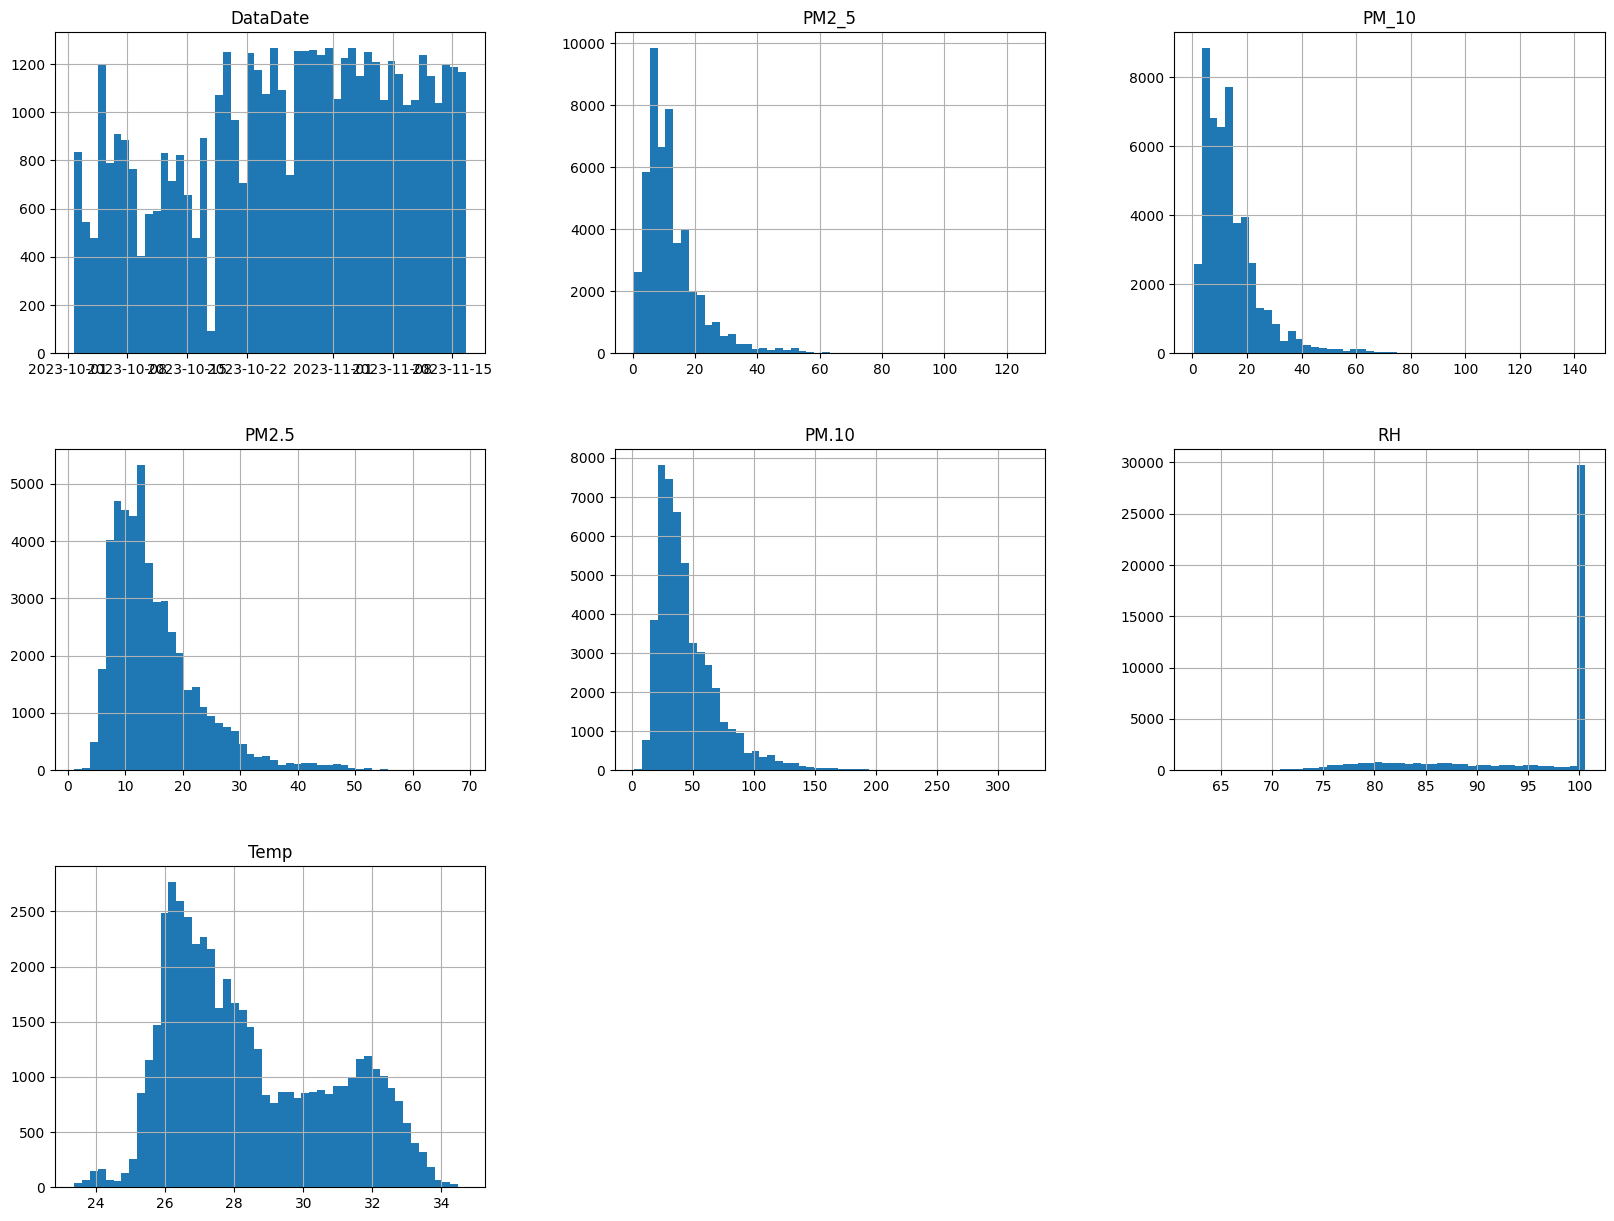

In [87]:
%matplotlib inline
merge_csv.hist(bins=50, figsize=(20,15))
plt.show()

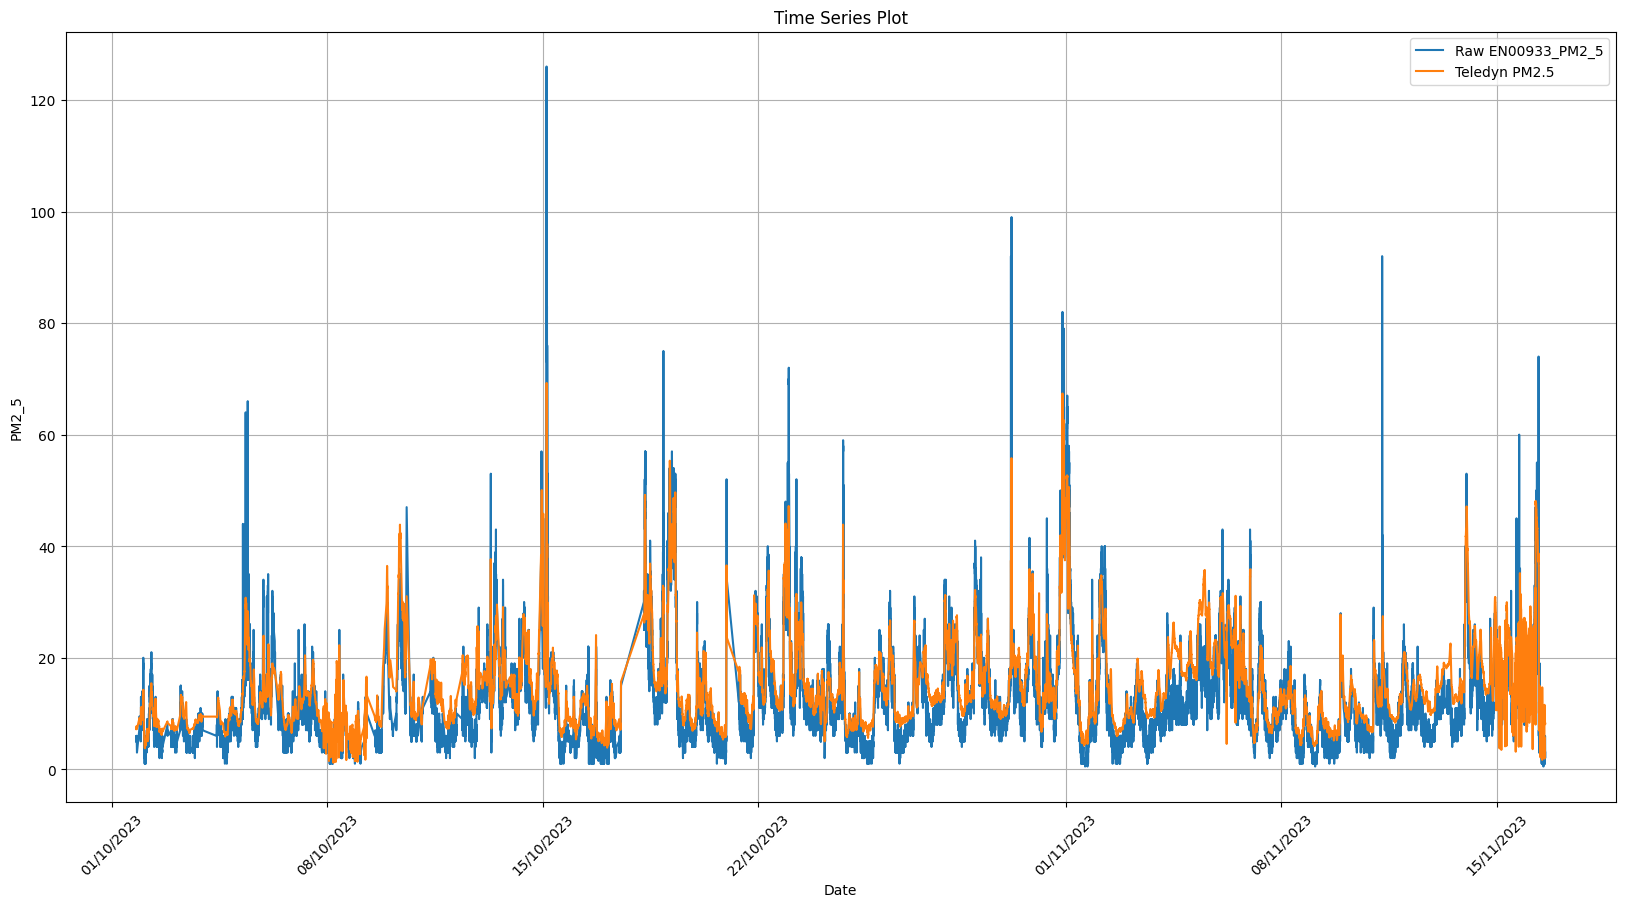

In [88]:
def plot_line_chart(df, sensor_id):
    plt.figure(figsize=(20, 10))
    sns.lineplot(x=df['DataDate'], y=df['PM2_5'], label=f'Raw {sensor_id}_PM2_5')
    sns.lineplot(x=df['DataDate'], y=df['PM2.5'], label='Teledyn PM2.5')

    plt.title('Time Series Plot')
    plt.xlabel('Date')
    plt.ylabel('PM2_5')
    plt.grid(True)
    plt.legend()

    # Format the date on the x-axis to show hours and minutes (H:S)
    date_format = DateFormatter("%d/%m/%Y")
    plt.gca().xaxis.set_major_formatter(date_format)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()
plot_line_chart(merge_csv, 'EN00933')

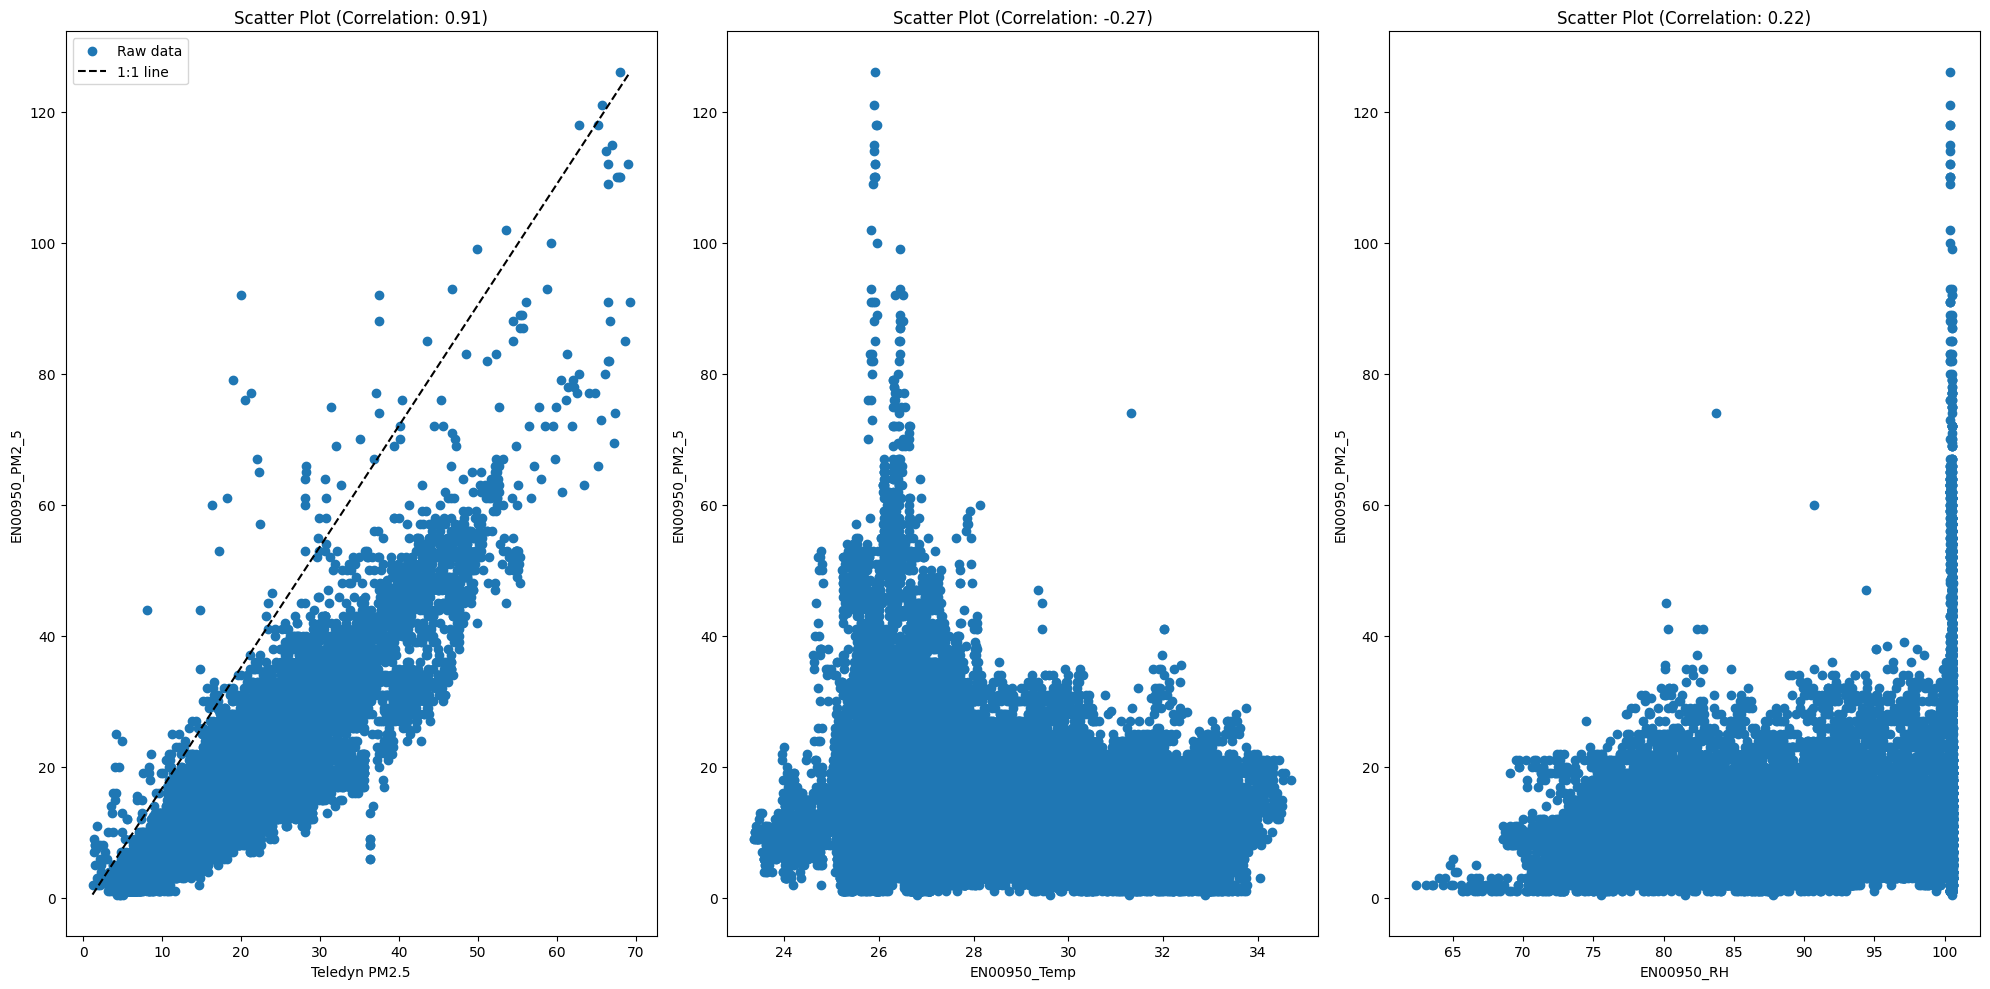

In [95]:
def correlation_scatter_plot_fxn(df, sensor_id):
    correlation_PM2_5 = df['PM2_5'].corr(df['PM2.5'])
    correlation_PM2_5_and_Temp = df['PM2_5'].corr(df['Temp'])
    correlation_PM2_5_and_RH = df['PM2_5'].corr(df['RH'])
    

    # Create a figure with three subplots in one row and three columns
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    # Plot the first scatter plot
    axes[0].scatter(df['PM2.5'], df['PM2_5'], label='Raw data')

    axes[0].plot([min(df['PM2.5']), max(df['PM2.5'])], [min(df['PM2_5']), max(df['PM2_5'])],
                 color='black', linestyle='--', label='1:1 line')
    
    axes[0].set_xlabel('Teledyn PM2.5')
    axes[0].set_ylabel(f'{sensor_id}_PM2_5')
    axes[0].set_title(f'Scatter Plot (Correlation: {correlation_PM2_5:.2f})')
    axes[0].legend()

    # Plot the second scatter plot
    axes[1].scatter(df['Temp'], df['PM2_5'])
    axes[1].set_xlabel(f'{sensor_id}_Temp')
    axes[1].set_ylabel(f'{sensor_id}_PM2_5')
    axes[1].set_title(f'Scatter Plot (Correlation: {correlation_PM2_5_and_Temp:.2f})')

    # Plot the third scatter plot
    axes[2].scatter(df['RH'], df['PM2_5'])
    axes[2].set_xlabel(f'{sensor_id}_RH')
    axes[2].set_ylabel(f'{sensor_id}_PM2_5')
    axes[2].set_title(f'Scatter Plot (Correlation: {correlation_PM2_5_and_RH:.2f})')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()
correlation_scatter_plot_fxn(merge_csv, 'EN00950')

In [91]:
corr_matrix = merge_csv.corr()
corr_matrix

,DataDate,PM2_5,PM_10,PM2.5,PM.10,RH,Temp
DataDate,1.000000,0.070031,0.070535,0.158745,0.182832,0.002890,0.129927
PM2_5,0.070031,1.000000,0.999154,0.908193,0.709039,0.223041,-0.272093
PM_10,0.070535,0.999154,1.000000,0.909017,0.712503,0.222338,-0.271503
PM2.5,0.158745,0.908193,0.909017,1.000000,0.880609,0.083277,-0.106863
PM.10,0.182832,0.709039,0.712503,0.880609,1.000000,-0.025180,0.024730
RH,0.002890,0.223041,0.222338,0.083277,-0.025180,1.000000,-0.899707
Temp,0.129927,-0.272093,-0.271503,-0.106863,0.024730,-0.899707,1.000000
